In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [3]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [4]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [5]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts


scenario_types = [
    'accelerating_at_traffic_light_with_lead', 
    'crossed_by_bike', 
    'crossed_by_vehicle', 
    'on_intersection', 
    'on_stopline_crosswalk', 
    'on_stopline_stop_sign', 
    'on_stopline_traffic_light', 
    'on_traffic_light_intersection', 
    'starting_protected_cross_turn', 
    'starting_protected_noncross_turn', 
    'starting_right_turn', 
    'starting_straight_stop_sign_intersection_traversal', 
    'starting_straight_traffic_light_intersection_traversal', 
    'starting_u_turn', 
    'starting_unprotected_cross_turn', 
    'starting_unprotected_noncross_turn', 
    'stationary_at_crosswalk', 
    'stationary_at_traffic_light_with_lead', 
    'stationary_at_traffic_light_without_lead', 
    'traversing_crosswalk', 
    'traversing_intersection', 
    'traversing_traffic_light_intersection'
    ]

#scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = 'train_boston'  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f'scenario_builder={scenario_builder}',
    'scenario_filter=all_scenarios', # [all_scenarios, val14_split]
    f'scenario_filter.scenario_types={scenario_types}', #there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
#    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
#    'scenario_filter.ego_displacement_minimum_m=10',  # use scenarios where the ego vehicle moves at least 10m
#    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
#    'scenario_filter.ego_start_speed_threshold=5',  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
#    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
#    'scenario_filter.map_names=us-ma-boston', # [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    'scenario_filter.num_scenarios_per_type=200',  # use 10 scenarios per scenario type
#     'scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']', # specific scenrios to simulate
#    'scenario_filter.limit_total_scenarios=0.01',  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
]
ckpt_dir = '/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt'
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    '+simulation=open_loop_boxes',# [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
    #'model=gc_pgp_model',
    #'model.aggregator.pre_train=false',
    # 'planner=pdm_hybrid_planner',
    # f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
    'planner=log_future_planner', # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
    #'model=urban_driver_open_loop_model',
    'ego_controller=perfect_tracking_controller',
    #'planner.ml_planner.model_config=${model}',
    #f'planner.ml_planner.checkpoint_path={obs_ckpt_dir}',
    #f'observation=idm_agents_observation',
    #'observation.model_config=${model}',
    #f'observation.checkpoint_path={ckpt_dir}',
    'worker=ray_distributed', # [sequential, ray_distributed]
    '+occlusion=true', #[true, false]
    '+occlusion.manager_type=wedge', #options: [range, shadow, wedge]
    #"hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
    *DATASET_PARAMS,
])

output_folder = cfg.output_dir
print('output_folder = \"' + output_folder + '\"')
# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48" 
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
#output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions: 

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions: 

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions: 

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"


# scenario types in valdation set:
## on_traffic_light_intersection
## accelerating_at_traffic_light_with_lead
##on_stopline_traffic_light
#starting_right_turn
#stationary_at_traffic_light_without_lead
##starting_protected_cross_turn
##starting_straight_traffic_light_intersection_traversal
##starting_unprotected_noncross_turn
##starting_u_turn
##stationary_at_traffic_light_with_lead
##on_intersection
##traversing_intersection
##crossed_by_vehicle
##starting_straight_stop_sign_intersection_traversal
##traversing_traffic_light_intersection
##starting_unprotected_cross_turn
##on_traffic_light_intersection
##starting_protected_noncross_turn

#put the above scenario types in the above comment into a list to simulate only those scenarios in the same order as they appear in the comments above




default_simulation
output_folder = "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.17.00.28.36"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-12-17 00:28:36,803 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-17 00:28:36,855 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-12-17 00:28:38,456	INFO worker.py:1636 -- Started a local Ray instance.


2023-12-17 00:28:39,097 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-12-17 00:28:39,097 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2023-12-17 00:28:39,098 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-17 00:28:39,098 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-17 00:28:39,098 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.17.00.28.36

2023-12-17 00:28:39,099 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:7

Ray objects: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


2023-12-17 00:28:52,382 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...
2023-12-17 00:28:52,551 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:78}  Building metric engines...DONE
2023-12-17 00:28:52,552 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building simulations from 3523 scenarios...
2023-12-17 00:29:05,554 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:142}  Building simulations...DONE!
2023-12-17 00:29:05,554 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:114}  Running simulation...
2023-12-17 00:29:05,554 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-12-17 00:29:05,554 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 3523 simulations using RayDistr

Ray objects:   0%|          | 0/3523 [00:00<?, ?it/s]

(wrapped_fn pid=167660) numrel agents 1


Ray objects:   1%|          | 32/3523 [00:15<36:29,  1.59it/s] 

(wrapped_fn pid=167645) numrel agents 2 [repeated 21x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Ray objects:   1%|▏         | 48/3523 [00:20<12:33,  4.61it/s]

(wrapped_fn pid=167647) numrel agents 5 [repeated 9x across cluster]


Ray objects:   2%|▏         | 66/3523 [00:26<28:57,  1.99it/s]

(wrapped_fn pid=167642) numrel agents 3 [repeated 5x across cluster]


Ray objects:   3%|▎         | 89/3523 [00:34<28:45,  1.99it/s]

(wrapped_fn pid=167666) numrel agents 1 [repeated 12x across cluster]


Ray objects:   3%|▎         | 103/3523 [00:39<26:21,  2.16it/s]

(wrapped_fn pid=167648) numrel agents 4 [repeated 7x across cluster]


Ray objects:   3%|▎         | 120/3523 [00:45<18:30,  3.07it/s]

(wrapped_fn pid=167656) numrel agents 2 [repeated 10x across cluster]


Ray objects:   4%|▍         | 141/3523 [00:51<21:31,  2.62it/s]

(wrapped_fn pid=167655) numrel agents 2 [repeated 10x across cluster]


Ray objects:   4%|▍         | 153/3523 [00:56<19:22,  2.90it/s]

(wrapped_fn pid=167652) numrel agents 6 [repeated 9x across cluster]


Ray objects:   5%|▍         | 173/3523 [01:02<19:58,  2.80it/s]

(wrapped_fn pid=167658) numrel agents 1 [repeated 10x across cluster]


Ray objects:   5%|▍         | 176/3523 [01:04<32:01,  1.74it/s]

(wrapped_fn pid=167669) 3


Ray objects:   5%|▌         | 187/3523 [01:08<17:05,  3.25it/s]

(wrapped_fn pid=167646) numrel agents 2 [repeated 9x across cluster]


Ray objects:   6%|▌         | 204/3523 [01:13<29:38,  1.87it/s]

(wrapped_fn pid=167648) numrel agents 2 [repeated 8x across cluster]


Ray objects:   6%|▌         | 219/3523 [01:18<15:13,  3.62it/s]

(wrapped_fn pid=167639) numrel agents 4 [repeated 9x across cluster]


Ray objects:   7%|▋         | 237/3523 [01:24<18:58,  2.89it/s]

(wrapped_fn pid=167642) numrel agents 4 [repeated 9x across cluster]


Ray objects:   7%|▋         | 251/3523 [01:29<20:29,  2.66it/s]

(wrapped_fn pid=167666) numrel agents 2 [repeated 10x across cluster]


Ray objects:   8%|▊         | 270/3523 [01:34<14:56,  3.63it/s]

(wrapped_fn pid=167660) numrel agents 2 [repeated 9x across cluster]


Ray objects:   8%|▊         | 287/3523 [01:39<10:36,  5.09it/s]

(wrapped_fn pid=167644) numrel agents 1 [repeated 11x across cluster]


Ray objects:   9%|▊         | 302/3523 [01:45<16:47,  3.20it/s]

(wrapped_fn pid=167653) numrel agents 3 [repeated 5x across cluster]


Ray objects:   9%|▉         | 320/3523 [01:51<10:52,  4.91it/s]

(wrapped_fn pid=167663) numrel agents 2 [repeated 8x across cluster]


Ray objects:  10%|▉         | 335/3523 [01:56<17:01,  3.12it/s]

(wrapped_fn pid=167659) numrel agents 1 [repeated 5x across cluster]


Ray objects:  10%|▉         | 351/3523 [02:01<16:37,  3.18it/s]

(wrapped_fn pid=167656) numrel agents 1 [repeated 8x across cluster]


Ray objects:  10%|█         | 367/3523 [02:07<18:55,  2.78it/s]

(wrapped_fn pid=167667) numrel agents 4 [repeated 10x across cluster]


Ray objects:  11%|█         | 377/3523 [02:12<21:31,  2.44it/s]

(wrapped_fn pid=167640) numrel agents 2 [repeated 9x across cluster]


Ray objects:  11%|█▏        | 397/3523 [02:16<15:01,  3.47it/s]

(wrapped_fn pid=167645) numrel agents 1 [repeated 10x across cluster]


Ray objects:  12%|█▏        | 407/3523 [02:22<36:20,  1.43it/s]

(wrapped_fn pid=167664) numrel agents 1 [repeated 6x across cluster]


Ray objects:  12%|█▏        | 430/3523 [02:27<10:56,  4.71it/s]

(wrapped_fn pid=167667) numrel agents 5 [repeated 14x across cluster]


Ray objects:  13%|█▎        | 448/3523 [02:35<13:26,  3.81it/s]

(wrapped_fn pid=167659) numrel agents 1 [repeated 9x across cluster]


Ray objects:  13%|█▎        | 464/3523 [02:40<12:37,  4.04it/s]

(wrapped_fn pid=167654) numrel agents 2 [repeated 9x across cluster]


Ray objects:  14%|█▎        | 476/3523 [02:46<36:39,  1.39it/s]

(wrapped_fn pid=167662) numrel agents 3 [repeated 6x across cluster]


Ray objects:  14%|█▍        | 495/3523 [02:51<16:45,  3.01it/s]

(wrapped_fn pid=167667) numrel agents 3 [repeated 9x across cluster]


Ray objects:  15%|█▍        | 511/3523 [02:59<37:40,  1.33it/s]

(wrapped_fn pid=167649) numrel agents 3 [repeated 2x across cluster]


Ray objects:  15%|█▌        | 536/3523 [03:05<17:09,  2.90it/s]

(wrapped_fn pid=167650) numrel agents 2 [repeated 10x across cluster]


Ray objects:  16%|█▌        | 550/3523 [03:11<21:29,  2.30it/s]

(wrapped_fn pid=167653) numrel agents 2 [repeated 7x across cluster]


Ray objects:  16%|█▌        | 572/3523 [03:16<09:17,  5.30it/s]

(wrapped_fn pid=167640) numrel agents 1 [repeated 14x across cluster]


Ray objects:  16%|█▋        | 579/3523 [03:21<30:04,  1.63it/s]

(wrapped_fn pid=167661) numrel agents 5 [repeated 4x across cluster]


Ray objects:  17%|█▋        | 601/3523 [03:27<09:02,  5.38it/s]

(wrapped_fn pid=167658) numrel agents 3 [repeated 11x across cluster]


Ray objects:  17%|█▋        | 614/3523 [03:33<39:34,  1.23it/s]

(wrapped_fn pid=167661) numrel agents 3 [repeated 3x across cluster]


Ray objects:  18%|█▊        | 638/3523 [03:39<17:00,  2.83it/s]

(wrapped_fn pid=167653) numrel agents 3 [repeated 10x across cluster]


Ray objects:  18%|█▊        | 651/3523 [03:45<17:27,  2.74it/s]

(wrapped_fn pid=167669) numrel agents 2 [repeated 5x across cluster]


Ray objects:  19%|█▉        | 669/3523 [03:50<24:31,  1.94it/s]

(wrapped_fn pid=167653) numrel agents 1 [repeated 7x across cluster]


Ray objects:  19%|█▉        | 682/3523 [03:55<19:45,  2.40it/s]

(wrapped_fn pid=167642) numrel agents 1 [repeated 5x across cluster]


Ray objects:  20%|█▉        | 702/3523 [04:01<12:10,  3.86it/s]

(wrapped_fn pid=167647) numrel agents 4 [repeated 9x across cluster]


Ray objects:  20%|██        | 715/3523 [04:06<18:17,  2.56it/s]

(wrapped_fn pid=167664) numrel agents 1 [repeated 3x across cluster]


Ray objects:  21%|██        | 731/3523 [04:12<26:36,  1.75it/s]

(wrapped_fn pid=167650) numrel agents 1 [repeated 7x across cluster]


Ray objects:  21%|██▏       | 752/3523 [04:18<11:11,  4.13it/s]

(wrapped_fn pid=167652) numrel agents 3 [repeated 12x across cluster]


Ray objects:  22%|██▏       | 763/3523 [04:23<17:00,  2.70it/s]

(wrapped_fn pid=167667) numrel agents 2 [repeated 7x across cluster]


Ray objects:  22%|██▏       | 783/3523 [04:29<14:29,  3.15it/s]

(wrapped_fn pid=167664) numrel agents 3 [repeated 12x across cluster]


Ray objects:  23%|██▎       | 798/3523 [04:35<17:26,  2.60it/s]

(wrapped_fn pid=167657) numrel agents 4 [repeated 6x across cluster]


Ray objects:  23%|██▎       | 822/3523 [04:42<16:32,  2.72it/s]

(wrapped_fn pid=167643) numrel agents 2 [repeated 12x across cluster]


Ray objects:  24%|██▍       | 839/3523 [04:48<09:53,  4.52it/s]

(wrapped_fn pid=167650) numrel agents 3 [repeated 11x across cluster]


Ray objects:  24%|██▍       | 855/3523 [04:54<21:05,  2.11it/s]

(wrapped_fn pid=167667) numrel agents 2 [repeated 7x across cluster]


Ray objects:  25%|██▍       | 871/3523 [04:59<09:37,  4.59it/s]

(wrapped_fn pid=167648) numrel agents 3 [repeated 9x across cluster]


Ray objects:  25%|██▌       | 887/3523 [05:04<14:30,  3.03it/s]

(wrapped_fn pid=167652) numrel agents 3 [repeated 7x across cluster]


Ray objects:  26%|██▌       | 900/3523 [05:09<18:53,  2.31it/s]

(wrapped_fn pid=167642) numrel agents 3 [repeated 5x across cluster]


Ray objects:  26%|██▌       | 923/3523 [05:16<14:03,  3.08it/s]

(wrapped_fn pid=167661) numrel agents 1 [repeated 11x across cluster]


Ray objects:  27%|██▋       | 945/3523 [05:24<11:39,  3.69it/s]

(wrapped_fn pid=167665) numrel agents 1 [repeated 11x across cluster]


Ray objects:  27%|██▋       | 964/3523 [05:30<12:57,  3.29it/s]

(wrapped_fn pid=167646) numrel agents 1 [repeated 4x across cluster]


Ray objects:  28%|██▊       | 978/3523 [05:36<16:34,  2.56it/s]

(wrapped_fn pid=167665) numrel agents 5 [repeated 7x across cluster]


Ray objects:  28%|██▊       | 994/3523 [05:40<09:13,  4.57it/s]

(wrapped_fn pid=167663) numrel agents 4 [repeated 11x across cluster]


Ray objects:  29%|██▊       | 1010/3523 [05:46<13:06,  3.19it/s]

(wrapped_fn pid=167647) numrel agents 2 [repeated 5x across cluster]


Ray objects:  29%|██▉       | 1026/3523 [05:51<20:53,  1.99it/s]

(wrapped_fn pid=167662) numrel agents 2 [repeated 8x across cluster]


Ray objects:  30%|██▉       | 1042/3523 [05:57<11:50,  3.49it/s]

(wrapped_fn pid=167646) numrel agents 4 [repeated 8x across cluster]


Ray objects:  30%|███       | 1060/3523 [06:02<12:12,  3.36it/s]

(wrapped_fn pid=167640) numrel agents 3 [repeated 9x across cluster]


Ray objects:  31%|███       | 1076/3523 [06:07<06:51,  5.94it/s]

(wrapped_fn pid=167661) numrel agents 2 [repeated 9x across cluster]


Ray objects:  31%|███       | 1090/3523 [06:13<14:29,  2.80it/s]

(wrapped_fn pid=167642) numrel agents 1 [repeated 7x across cluster]


Ray objects:  31%|███▏      | 1104/3523 [06:18<10:14,  3.93it/s]

(wrapped_fn pid=167659) numrel agents 1 [repeated 9x across cluster]


Ray objects:  32%|███▏      | 1119/3523 [06:23<14:35,  2.75it/s]

(wrapped_fn pid=167651) numrel agents 1 [repeated 8x across cluster]


Ray objects:  32%|███▏      | 1137/3523 [06:29<13:38,  2.91it/s]

(wrapped_fn pid=167652) numrel agents 1 [repeated 10x across cluster]


Ray objects:  33%|███▎      | 1150/3523 [06:34<12:58,  3.05it/s]

(wrapped_fn pid=167667) numrel agents 5 [repeated 9x across cluster]


Ray objects:  33%|███▎      | 1169/3523 [06:41<13:31,  2.90it/s]

(wrapped_fn pid=167646) numrel agents 2 [repeated 5x across cluster]


Ray objects:  34%|███▎      | 1188/3523 [06:46<08:19,  4.68it/s]

(wrapped_fn pid=167640) numrel agents 1 [repeated 9x across cluster]


Ray objects:  34%|███▍      | 1202/3523 [06:51<14:12,  2.72it/s]

(wrapped_fn pid=167658) numrel agents 6 [repeated 6x across cluster]


Ray objects:  35%|███▍      | 1219/3523 [06:57<09:24,  4.08it/s]

(wrapped_fn pid=167644) numrel agents 2 [repeated 5x across cluster]


Ray objects:  35%|███▍      | 1229/3523 [07:01<12:14,  3.12it/s]

(wrapped_fn pid=167650) numrel agents 1 [repeated 5x across cluster]


Ray objects:  35%|███▌      | 1249/3523 [07:08<12:49,  2.96it/s]

(wrapped_fn pid=167642) numrel agents 2 [repeated 9x across cluster]


Ray objects:  36%|███▌      | 1264/3523 [07:13<16:11,  2.33it/s]

(wrapped_fn pid=167660) numrel agents 2 [repeated 8x across cluster]


Ray objects:  36%|███▋      | 1285/3523 [07:18<08:42,  4.28it/s]

(wrapped_fn pid=167647) numrel agents 2 [repeated 11x across cluster]


Ray objects:  37%|███▋      | 1300/3523 [07:25<15:01,  2.46it/s]

(wrapped_fn pid=167663) numrel agents 1 [repeated 5x across cluster]


Ray objects:  38%|███▊      | 1323/3523 [07:31<07:50,  4.68it/s]

(wrapped_fn pid=167656) numrel agents 2 [repeated 14x across cluster]


Ray objects:  38%|███▊      | 1334/3523 [07:37<14:45,  2.47it/s]

(wrapped_fn pid=167644) numrel agents 3 [repeated 9x across cluster]


Ray objects:  39%|███▊      | 1357/3523 [07:44<14:42,  2.46it/s]

(wrapped_fn pid=167654) numrel agents 2 [repeated 15x across cluster]


Ray objects:  39%|███▉      | 1372/3523 [07:50<12:49,  2.80it/s]

(wrapped_fn pid=167641) numrel agents 4 [repeated 7x across cluster]


Ray objects:  39%|███▉      | 1389/3523 [07:55<10:55,  3.25it/s]

(wrapped_fn pid=167653) numrel agents 7 [repeated 9x across cluster]


Ray objects:  40%|███▉      | 1405/3523 [08:01<07:43,  4.57it/s]

(wrapped_fn pid=167644) numrel agents 4 [repeated 10x across cluster]


Ray objects:  40%|████      | 1423/3523 [08:07<07:20,  4.76it/s]

(wrapped_fn pid=167638) numrel agents 3 [repeated 8x across cluster]


Ray objects:  41%|████      | 1441/3523 [08:13<15:35,  2.23it/s]

(wrapped_fn pid=167644) numrel agents 3 [repeated 9x across cluster]


Ray objects:  41%|████▏     | 1456/3523 [08:19<11:31,  2.99it/s]

(wrapped_fn pid=167643) numrel agents 2 [repeated 9x across cluster]


Ray objects:  42%|████▏     | 1473/3523 [08:24<10:58,  3.11it/s]

(wrapped_fn pid=167664) numrel agents 1 [repeated 7x across cluster]


Ray objects:  42%|████▏     | 1490/3523 [08:30<13:39,  2.48it/s]

(wrapped_fn pid=167639) numrel agents 1 [repeated 9x across cluster]


Ray objects:  43%|████▎     | 1511/3523 [08:37<13:35,  2.47it/s]

(wrapped_fn pid=167644) numrel agents 5 [repeated 12x across cluster]


Ray objects:  43%|████▎     | 1525/3523 [08:42<09:25,  3.54it/s]

(wrapped_fn pid=167645) numrel agents 2 [repeated 8x across cluster]


Ray objects:  44%|████▍     | 1545/3523 [08:48<11:47,  2.80it/s]

(wrapped_fn pid=167669) numrel agents 2 [repeated 8x across cluster]


Ray objects:  44%|████▍     | 1561/3523 [08:54<08:31,  3.84it/s]

(wrapped_fn pid=167645) numrel agents 2 [repeated 10x across cluster]


Ray objects:  45%|████▍     | 1576/3523 [08:59<12:17,  2.64it/s]

(wrapped_fn pid=167667) numrel agents 3 [repeated 7x across cluster]


Ray objects:  45%|████▌     | 1596/3523 [09:05<09:36,  3.34it/s]

(wrapped_fn pid=167639) numrel agents 5 [repeated 10x across cluster]


Ray objects:  46%|████▌     | 1608/3523 [09:11<15:00,  2.13it/s]

(wrapped_fn pid=167648) numrel agents 2 [repeated 6x across cluster]


Ray objects:  46%|████▌     | 1626/3523 [09:17<18:29,  1.71it/s]

(wrapped_fn pid=167647) numrel agents 3 [repeated 10x across cluster]


Ray objects:  47%|████▋     | 1643/3523 [09:23<08:52,  3.53it/s]

(wrapped_fn pid=167640) numrel agents 1 [repeated 12x across cluster]


Ray objects:  47%|████▋     | 1659/3523 [09:28<10:32,  2.95it/s]

(wrapped_fn pid=167645) numrel agents 2 [repeated 10x across cluster]


Ray objects:  47%|████▋     | 1671/3523 [09:33<10:48,  2.86it/s]

(wrapped_fn pid=167644) numrel agents 1 [repeated 7x across cluster]


Ray objects:  48%|████▊     | 1688/3523 [09:38<10:17,  2.97it/s]

(wrapped_fn pid=167667) numrel agents 1 [repeated 9x across cluster]


Ray objects:  48%|████▊     | 1702/3523 [09:43<10:12,  2.97it/s]

(wrapped_fn pid=167641) numrel agents 4 [repeated 7x across cluster]


Ray objects:  49%|████▊     | 1714/3523 [09:47<06:14,  4.83it/s]

(wrapped_fn pid=167658)  1


Ray objects:  49%|████▉     | 1720/3523 [09:49<11:30,  2.61it/s]

(wrapped_fn pid=167649) numrel agents 7 [repeated 10x across cluster]


Ray objects:  49%|████▉     | 1733/3523 [09:54<10:54,  2.74it/s]

(wrapped_fn pid=167646) numrel agents 1 [repeated 6x across cluster]


Ray objects:  50%|████▉     | 1750/3523 [09:59<09:05,  3.25it/s]

(wrapped_fn pid=167657) numrel agents 3 [repeated 8x across cluster]


Ray objects:  50%|█████     | 1765/3523 [10:04<13:31,  2.17it/s]

(wrapped_fn pid=167654) numrel agents 2 [repeated 6x across cluster]


Ray objects:  51%|█████     | 1784/3523 [10:11<07:14,  4.01it/s]

(wrapped_fn pid=167652) numrel agents 1 [repeated 10x across cluster]


Ray objects:  51%|█████     | 1796/3523 [10:15<07:36,  3.78it/s]

(wrapped_fn pid=167654) numrel agents 3 [repeated 7x across cluster]


Ray objects:  51%|█████▏    | 1811/3523 [10:21<16:36,  1.72it/s]

(wrapped_fn pid=167667) numrel agents 8 [repeated 7x across cluster]


Ray objects:  52%|█████▏    | 1833/3523 [10:27<06:42,  4.20it/s]

(wrapped_fn pid=167642) numrel agents 1 [repeated 11x across cluster]


Ray objects:  52%|█████▏    | 1846/3523 [10:32<09:29,  2.95it/s]

(wrapped_fn pid=167645) numrel agents 1 [repeated 8x across cluster]


Ray objects:  53%|█████▎    | 1864/3523 [10:37<06:14,  4.43it/s]

(wrapped_fn pid=167669) numrel agents 1 [repeated 12x across cluster]


Ray objects:  53%|█████▎    | 1877/3523 [10:42<10:51,  2.53it/s]

(wrapped_fn pid=167640) numrel agents 4 [repeated 6x across cluster]


Ray objects:  54%|█████▍    | 1896/3523 [10:47<04:12,  6.46it/s]

(wrapped_fn pid=167658) numrel agents 4 [repeated 15x across cluster]


Ray objects:  54%|█████▍    | 1910/3523 [10:53<12:29,  2.15it/s]

(wrapped_fn pid=167662) numrel agents 1 [repeated 6x across cluster]


Ray objects:  55%|█████▍    | 1931/3523 [11:01<16:03,  1.65it/s]

(wrapped_fn pid=167655) numrel agents 1 [repeated 10x across cluster]


Ray objects:  55%|█████▌    | 1949/3523 [11:06<06:09,  4.26it/s]

(wrapped_fn pid=167664) numrel agents 4 [repeated 12x across cluster]


Ray objects:  56%|█████▌    | 1961/3523 [11:11<11:55,  2.18it/s]

(wrapped_fn pid=167642) numrel agents 2 [repeated 7x across cluster]


Ray objects:  56%|█████▌    | 1981/3523 [11:18<16:51,  1.52it/s]

(wrapped_fn pid=167640) numrel agents 1 [repeated 10x across cluster]


Ray objects:  57%|█████▋    | 2006/3523 [11:25<08:38,  2.93it/s]

(wrapped_fn pid=167643) numrel agents 1 [repeated 11x across cluster]


Ray objects:  57%|█████▋    | 2017/3523 [11:29<07:41,  3.26it/s]

(wrapped_fn pid=167648) numrel agents 3 [repeated 4x across cluster]


Ray objects:  58%|█████▊    | 2038/3523 [11:35<07:00,  3.53it/s]

(wrapped_fn pid=167662) numrel agents 2 [repeated 10x across cluster]


Ray objects:  58%|█████▊    | 2049/3523 [11:40<09:18,  2.64it/s]

(wrapped_fn pid=167664) numrel agents 6 [repeated 8x across cluster]


Ray objects:  59%|█████▊    | 2065/3523 [11:46<07:00,  3.47it/s]

(wrapped_fn pid=167655) numrel agents 1 [repeated 9x across cluster]


Ray objects:  59%|█████▉    | 2080/3523 [11:50<04:47,  5.02it/s]

(wrapped_fn pid=167662) numrel agents 2 [repeated 9x across cluster]


Ray objects:  60%|█████▉    | 2098/3523 [11:57<04:59,  4.76it/s]

(wrapped_fn pid=167663) numrel agents 4 [repeated 7x across cluster]


Ray objects:  60%|█████▉    | 2111/3523 [12:02<11:57,  1.97it/s]

(wrapped_fn pid=167656) numrel agents 1 [repeated 4x across cluster]


Ray objects:  60%|██████    | 2129/3523 [12:07<08:16,  2.81it/s]

(wrapped_fn pid=167663) numrel agents 2 [repeated 9x across cluster]


Ray objects:  61%|██████    | 2145/3523 [12:12<06:39,  3.45it/s]

(wrapped_fn pid=167662) numrel agents 1 [repeated 10x across cluster]


Ray objects:  61%|██████▏   | 2163/3523 [12:18<10:07,  2.24it/s]

(wrapped_fn pid=167644) numrel agents 1 [repeated 10x across cluster]


Ray objects:  62%|██████▏   | 2180/3523 [12:24<10:59,  2.04it/s]

(wrapped_fn pid=167647) numrel agents 1 [repeated 9x across cluster]


Ray objects:  62%|██████▏   | 2196/3523 [12:30<07:49,  2.82it/s]

(wrapped_fn pid=167640) numrel agents 4 [repeated 7x across cluster]


Ray objects:  63%|██████▎   | 2219/3523 [12:37<07:10,  3.03it/s]

(wrapped_fn pid=167657) numrel agents 4 [repeated 8x across cluster]


Ray objects:  63%|██████▎   | 2235/3523 [12:43<05:57,  3.60it/s]

(wrapped_fn pid=167652) numrel agents 1 [repeated 6x across cluster]


Ray objects:  64%|██████▎   | 2243/3523 [12:45<05:33,  3.84it/s]

(wrapped_fn pid=167649)  6


Ray objects:  64%|██████▍   | 2248/3523 [12:47<08:05,  2.63it/s]

(wrapped_fn pid=167666) numrel agents 3 [repeated 9x across cluster]


Ray objects:  64%|██████▍   | 2262/3523 [12:53<07:13,  2.91it/s]

(wrapped_fn pid=167643) numrel agents 2 [repeated 10x across cluster]


Ray objects:  65%|██████▍   | 2279/3523 [12:58<05:58,  3.47it/s]

(wrapped_fn pid=167644) numrel agents 2 [repeated 7x across cluster]


Ray objects:  65%|██████▌   | 2295/3523 [13:04<07:52,  2.60it/s]

(wrapped_fn pid=167650) numrel agents 3 [repeated 9x across cluster]


Ray objects:  66%|██████▌   | 2311/3523 [13:09<07:16,  2.78it/s]

(wrapped_fn pid=167651) numrel agents 1 [repeated 8x across cluster]


Ray objects:  66%|██████▌   | 2325/3523 [13:14<08:43,  2.29it/s]

(wrapped_fn pid=167654) numrel agents 2 [repeated 10x across cluster]


Ray objects:  66%|██████▋   | 2341/3523 [13:19<05:02,  3.91it/s]

(wrapped_fn pid=167653) numrel agents 4 [repeated 10x across cluster]


Ray objects:  67%|██████▋   | 2357/3523 [13:25<05:19,  3.65it/s]

(wrapped_fn pid=167641) numrel agents 1 [repeated 8x across cluster]


Ray objects:  67%|██████▋   | 2374/3523 [13:30<04:25,  4.33it/s]

(wrapped_fn pid=167669) numrel agents 2 [repeated 6x across cluster]


Ray objects:  68%|██████▊   | 2387/3523 [13:36<10:59,  1.72it/s]

(wrapped_fn pid=167650) numrel agents 3 [repeated 9x across cluster]


Ray objects:  68%|██████▊   | 2404/3523 [13:42<05:44,  3.24it/s]

(wrapped_fn pid=167644) numrel agents 3 [repeated 9x across cluster]


Ray objects:  69%|██████▊   | 2418/3523 [13:46<07:35,  2.42it/s]

(wrapped_fn pid=167646) numrel agents 3 [repeated 9x across cluster]


Ray objects:  69%|██████▉   | 2436/3523 [13:52<06:01,  3.01it/s]

(wrapped_fn pid=167656) numrel agents 3 [repeated 13x across cluster]


Ray objects:  70%|██████▉   | 2449/3523 [13:57<10:45,  1.66it/s]

(wrapped_fn pid=167661) numrel agents 4 [repeated 7x across cluster]


Ray objects:  70%|███████   | 2470/3523 [14:03<03:32,  4.96it/s]

(wrapped_fn pid=167643) numrel agents 4 [repeated 10x across cluster]


Ray objects:  70%|███████   | 2480/3523 [14:07<11:56,  1.46it/s]

(wrapped_fn pid=167667) numrel agents 6 [repeated 5x across cluster]


Ray objects:  71%|███████   | 2498/3523 [14:13<03:46,  4.53it/s]

(wrapped_fn pid=167652) numrel agents 7 [repeated 9x across cluster]


Ray objects:  71%|███████▏  | 2513/3523 [14:20<03:42,  4.55it/s]

(wrapped_fn pid=167649) numrel agents 2 [repeated 8x across cluster]


Ray objects:  72%|███████▏  | 2528/3523 [14:25<04:20,  3.83it/s]

(wrapped_fn pid=167652) numrel agents 4 [repeated 8x across cluster]


Ray objects:  72%|███████▏  | 2543/3523 [14:30<03:47,  4.31it/s]

(wrapped_fn pid=167648) numrel agents 1 [repeated 10x across cluster]


Ray objects:  73%|███████▎  | 2560/3523 [14:36<04:06,  3.90it/s]

(wrapped_fn pid=167651) numrel agents 4 [repeated 10x across cluster]


Ray objects:  73%|███████▎  | 2581/3523 [14:46<12:36,  1.24it/s]

(wrapped_fn pid=167668) numrel agents 3 [repeated 10x across cluster]


Ray objects:  74%|███████▍  | 2600/3523 [14:50<03:23,  4.54it/s]

(wrapped_fn pid=167640) numrel agents 4 [repeated 5x across cluster]


Ray objects:  74%|███████▍  | 2612/3523 [14:55<06:07,  2.48it/s]

(wrapped_fn pid=167668) numrel agents 1 [repeated 10x across cluster]


Ray objects:  75%|███████▍  | 2633/3523 [15:02<03:13,  4.59it/s]

(wrapped_fn pid=167667) numrel agents 6 [repeated 8x across cluster]


Ray objects:  75%|███████▌  | 2650/3523 [15:08<06:57,  2.09it/s]

(wrapped_fn pid=167662) numrel agents 1 [repeated 10x across cluster]


Ray objects:  76%|███████▌  | 2663/3523 [15:12<04:18,  3.33it/s]

(wrapped_fn pid=167653) numrel agents 5 [repeated 8x across cluster]


Ray objects:  76%|███████▌  | 2685/3523 [15:20<06:54,  2.02it/s]

(wrapped_fn pid=167638) numrel agents 2 [repeated 8x across cluster]


Ray objects:  77%|███████▋  | 2701/3523 [15:25<04:46,  2.87it/s]

(wrapped_fn pid=167666) numrel agents 2 [repeated 12x across cluster]


Ray objects:  77%|███████▋  | 2714/3523 [15:29<04:25,  3.05it/s]

(wrapped_fn pid=167663) numrel agents 1 [repeated 4x across cluster]


Ray objects:  78%|███████▊  | 2733/3523 [15:37<06:10,  2.13it/s]

(wrapped_fn pid=167645) numrel agents 3 [repeated 11x across cluster]


Ray objects:  78%|███████▊  | 2751/3523 [15:42<03:34,  3.60it/s]

(wrapped_fn pid=167648) numrel agents 1 [repeated 10x across cluster]


Ray objects:  79%|███████▊  | 2766/3523 [15:48<04:09,  3.04it/s]

(wrapped_fn pid=167649) numrel agents 1 [repeated 8x across cluster]


Ray objects:  79%|███████▉  | 2785/3523 [15:53<01:44,  7.04it/s]

(wrapped_fn pid=167663) numrel agents 4 [repeated 10x across cluster]


Ray objects:  80%|███████▉  | 2802/3523 [16:00<04:00,  3.00it/s]

(wrapped_fn pid=167661) numrel agents 1 [repeated 5x across cluster]


Ray objects:  80%|███████▉  | 2816/3523 [16:06<04:27,  2.65it/s]

(wrapped_fn pid=167653) numrel agents 1 [repeated 6x across cluster]


Ray objects:  81%|████████  | 2837/3523 [16:12<04:28,  2.56it/s]

(wrapped_fn pid=167642) numrel agents 2 [repeated 6x across cluster]


Ray objects:  81%|████████  | 2850/3523 [16:17<04:52,  2.30it/s]

(wrapped_fn pid=167657) numrel agents 2 [repeated 8x across cluster]


Ray objects:  81%|████████▏ | 2868/3523 [16:22<04:25,  2.46it/s]

(wrapped_fn pid=167642) numrel agents 2 [repeated 11x across cluster]


Ray objects:  82%|████████▏ | 2882/3523 [16:28<06:09,  1.73it/s]

(wrapped_fn pid=167656) numrel agents 3 [repeated 8x across cluster]


Ray objects:  82%|████████▏ | 2899/3523 [16:33<02:47,  3.73it/s]

(wrapped_fn pid=167659) numrel agents 1 [repeated 12x across cluster]


Ray objects:  83%|████████▎ | 2912/3523 [16:37<03:17,  3.10it/s]

(wrapped_fn pid=167661) numrel agents 3 [repeated 7x across cluster]


Ray objects:  83%|████████▎ | 2928/3523 [16:43<05:09,  1.92it/s]

(wrapped_fn pid=167640) numrel agents 1 [repeated 6x across cluster]


Ray objects:  84%|████████▎ | 2948/3523 [16:48<02:25,  3.95it/s]

(wrapped_fn pid=167642) numrel agents 5 [repeated 10x across cluster]


Ray objects:  84%|████████▍ | 2964/3523 [16:54<02:53,  3.21it/s]

(wrapped_fn pid=167657) numrel agents 1 [repeated 9x across cluster]


Ray objects:  85%|████████▍ | 2980/3523 [16:59<02:14,  4.05it/s]

(wrapped_fn pid=167650) numrel agents 2 [repeated 6x across cluster]


Ray objects:  85%|████████▍ | 2992/3523 [17:04<03:51,  2.30it/s]

(wrapped_fn pid=167664) numrel agents 3 [repeated 6x across cluster]


Ray objects:  85%|████████▌ | 3006/3523 [17:09<05:04,  1.70it/s]

(wrapped_fn pid=167669) numrel agents 2 [repeated 8x across cluster]


Ray objects:  86%|████████▌ | 3024/3523 [17:14<01:44,  4.76it/s]

(wrapped_fn pid=167667) numrel agents 2 [repeated 7x across cluster]


Ray objects:  86%|████████▌ | 3036/3523 [17:20<03:55,  2.06it/s]

(wrapped_fn pid=167638) numrel agents 2 [repeated 8x across cluster]


Ray objects:  87%|████████▋ | 3054/3523 [17:26<02:14,  3.49it/s]

(wrapped_fn pid=167667) numrel agents 2 [repeated 10x across cluster]


Ray objects:  87%|████████▋ | 3067/3523 [17:30<03:30,  2.16it/s]

(wrapped_fn pid=167669) numrel agents 2 [repeated 8x across cluster]


Ray objects:  87%|████████▋ | 3082/3523 [17:35<01:22,  5.35it/s]

(wrapped_fn pid=167658) numrel agents 1 [repeated 8x across cluster]


Ray objects:  88%|████████▊ | 3098/3523 [17:40<01:55,  3.68it/s]

(wrapped_fn pid=167657) numrel agents 6 [repeated 7x across cluster]


Ray objects:  88%|████████▊ | 3112/3523 [17:46<02:12,  3.10it/s]

(wrapped_fn pid=167639) numrel agents 6 [repeated 7x across cluster]


Ray objects:  89%|████████▉ | 3129/3523 [17:52<02:34,  2.55it/s]

(wrapped_fn pid=167657) numrel agents 2 [repeated 7x across cluster]


Ray objects:  89%|████████▉ | 3145/3523 [17:58<03:00,  2.09it/s]

(wrapped_fn pid=167659) numrel agents 3 [repeated 9x across cluster]


Ray objects:  90%|████████▉ | 3160/3523 [18:03<02:19,  2.61it/s]

(wrapped_fn pid=167662) numrel agents 2 [repeated 8x across cluster]


Ray objects:  90%|█████████ | 3177/3523 [18:08<01:41,  3.41it/s]

(wrapped_fn pid=167644) numrel agents 3 [repeated 6x across cluster]


Ray objects:  91%|█████████ | 3193/3523 [18:13<01:12,  4.55it/s]

(wrapped_fn pid=167638) numrel agents 1 [repeated 6x across cluster]


Ray objects:  91%|█████████ | 3204/3523 [18:19<03:30,  1.52it/s]

(wrapped_fn pid=167641) numrel agents 3 [repeated 9x across cluster]


Ray objects:  91%|█████████▏| 3220/3523 [18:23<02:09,  2.34it/s]

(wrapped_fn pid=167642) numrel agents 5 [repeated 8x across cluster]


Ray objects:  92%|█████████▏| 3236/3523 [18:29<02:04,  2.30it/s]

(wrapped_fn pid=167645) numrel agents 4 [repeated 8x across cluster]


Ray objects:  92%|█████████▏| 3249/3523 [18:33<02:11,  2.08it/s]

(wrapped_fn pid=167642) numrel agents 3 [repeated 8x across cluster]


Ray objects:  93%|█████████▎| 3267/3523 [18:39<01:31,  2.80it/s]

(wrapped_fn pid=167653) numrel agents 1 [repeated 11x across cluster]


Ray objects:  93%|█████████▎| 3281/3523 [18:44<02:05,  1.93it/s]

(wrapped_fn pid=167642) numrel agents 1 [repeated 5x across cluster]


Ray objects:  94%|█████████▎| 3298/3523 [18:49<00:59,  3.78it/s]

(wrapped_fn pid=167638) numrel agents 2 [repeated 9x across cluster]


Ray objects:  94%|█████████▍| 3312/3523 [18:54<01:26,  2.44it/s]

(wrapped_fn pid=167665) numrel agents 4 [repeated 10x across cluster]


Ray objects:  94%|█████████▍| 3325/3523 [18:59<00:56,  3.49it/s]

(wrapped_fn pid=167639) numrel agents 2 [repeated 8x across cluster]


Ray objects:  95%|█████████▍| 3345/3523 [19:06<01:32,  1.93it/s]

(wrapped_fn pid=167641) numrel agents 3 [repeated 8x across cluster]


Ray objects:  95%|█████████▌| 3362/3523 [19:11<00:42,  3.77it/s]

(wrapped_fn pid=167663) numrel agents 4 [repeated 6x across cluster]


Ray objects:  96%|█████████▌| 3379/3523 [19:17<00:54,  2.64it/s]

(wrapped_fn pid=167643) numrel agents 4 [repeated 6x across cluster]


Ray objects:  96%|█████████▋| 3397/3523 [19:24<01:19,  1.59it/s]

(wrapped_fn pid=167661) numrel agents 2 [repeated 6x across cluster]


Ray objects:  97%|█████████▋| 3413/3523 [19:29<00:41,  2.68it/s]

(wrapped_fn pid=167669) numrel agents 1 [repeated 7x across cluster]


Ray objects:  97%|█████████▋| 3428/3523 [19:34<00:36,  2.61it/s]

(wrapped_fn pid=167668) numrel agents 1 [repeated 6x across cluster]


Ray objects:  98%|█████████▊| 3441/3523 [19:40<00:25,  3.21it/s]

(wrapped_fn pid=167651) numrel agents 1 [repeated 7x across cluster]


Ray objects:  98%|█████████▊| 3460/3523 [19:45<00:22,  2.82it/s]

(wrapped_fn pid=167667) numrel agents 1 [repeated 7x across cluster]


Ray objects:  99%|█████████▊| 3475/3523 [19:51<00:19,  2.45it/s]

(wrapped_fn pid=167638) numrel agents 3 [repeated 9x across cluster]


Ray objects:  99%|█████████▉| 3490/3523 [19:56<00:11,  2.88it/s]

(wrapped_fn pid=167669) numrel agents 3 [repeated 9x across cluster]


Ray objects: 100%|█████████▉| 3507/3523 [20:01<00:04,  3.75it/s]

(wrapped_fn pid=167651) numrel agents 1 [repeated 11x across cluster]


Ray objects: 100%|██████████| 3523/3523 [20:04<00:00,  2.92it/s]


2023-12-17 00:49:12,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 3523
2023-12-17 00:49:12,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-17 00:49:12,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-17 00:49:12,576 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.17.00.28.36/runner_report.parquet
2023-12-17 00:49:12,577 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:20:35 [HH:MM:SS]
2023-12-17 00:49:33,906 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:21 [HH:MM:SS]
2023-12-17 00:49:34,251 INFO 

Rendering histograms: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


2023-12-17 00:49:40,058 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-12-17 00:49:40,062 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


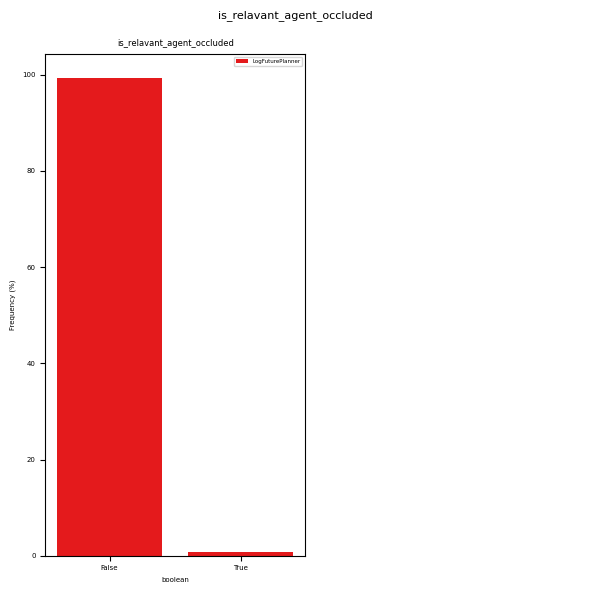

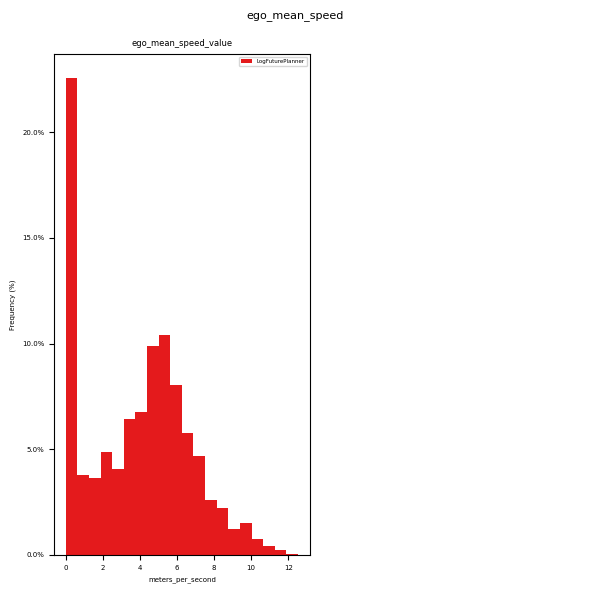

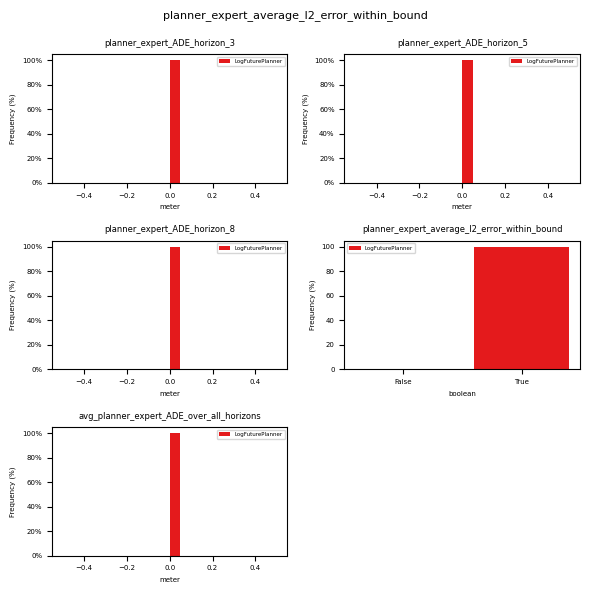

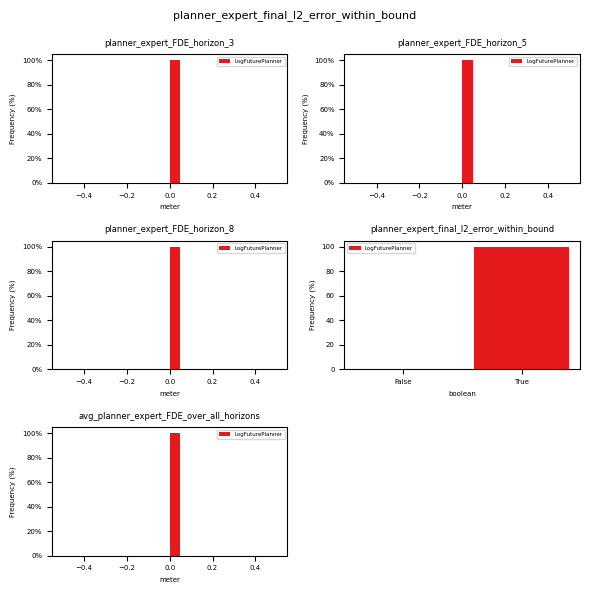

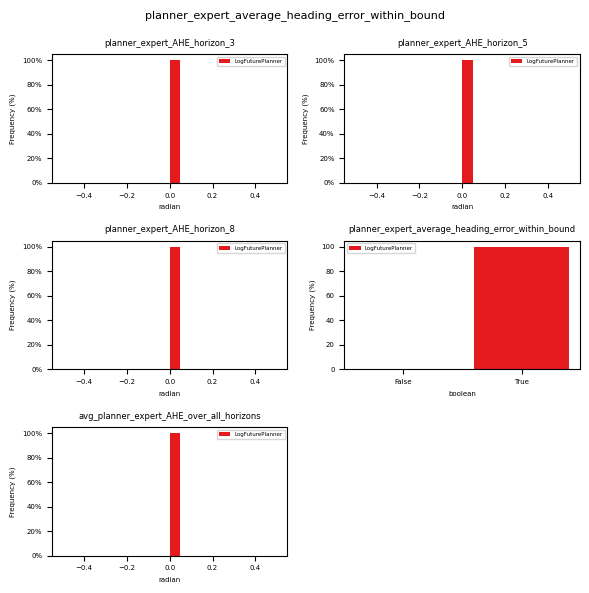

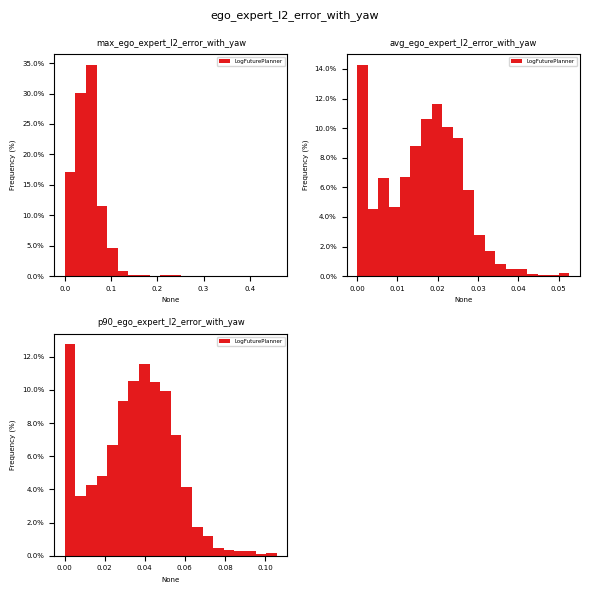

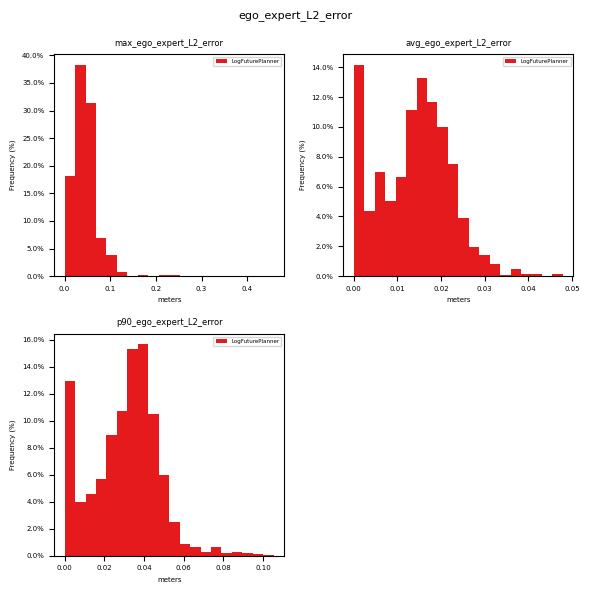

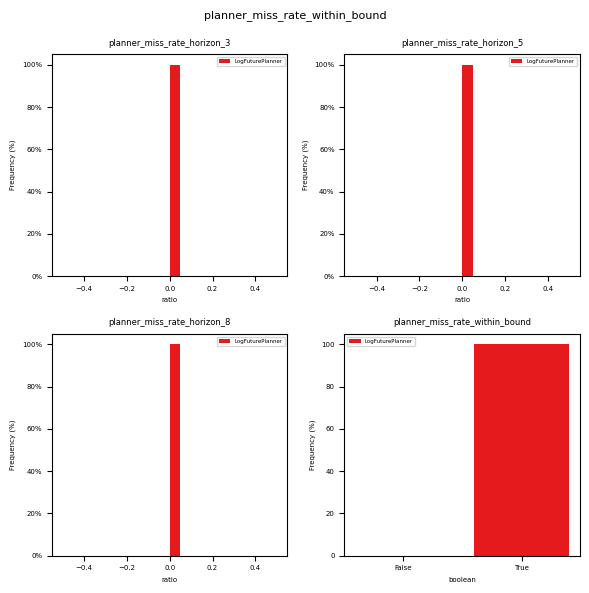

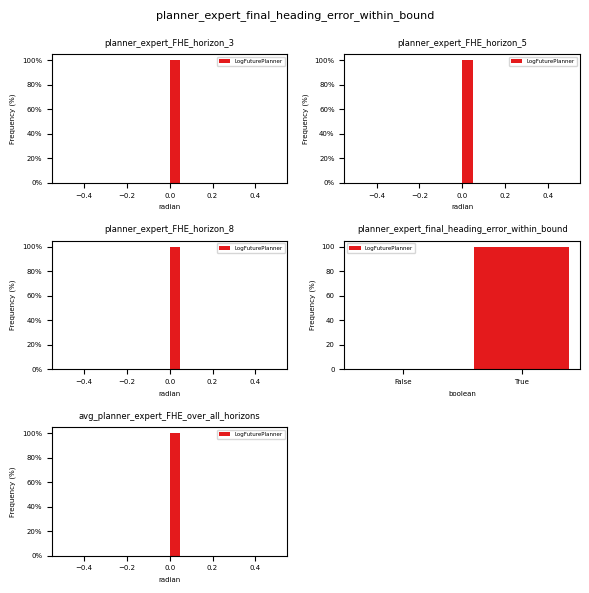

In [6]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [7]:
output_folder_alt = []
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48" )
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13" )
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48")



In [8]:
#output_folder = '../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.21.19.06'
#output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'scenario_builder={scenario_builder}',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={output_folder}',  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard 
])


## Launch nuBoard (open in new tab - recommended)

In [9]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-17 00:49:42,944 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-17 00:49:42,964 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-17 00:49:42,965 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-17 00:49:42,965 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-12-17 00:49:42,965 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2023-12-17 00:49:42,966 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 1073.55ms


2023-12-17 00:49:45,282 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.60ms
2023-12-17 00:49:45,282 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-17 00:49:45,283 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.60ms


2023-12-17 00:49:46,022 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-17 00:49:46,736 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0214 seconds.
2023-12-17 00:49:46,828 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 1345.17ms


INFO:tornado.access:200 GET / (127.0.0.1) 1345.17ms
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


2023-12-17 00:55:23,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.4162 seconds.
2023-12-17 00:56:21,566 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2023-12-17 00:56:22,472 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


2023-12-17 00:58:44,511 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.0737 seconds.
2023-12-17 00:59:22,666 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2023-12-17 00:59:23,541 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s]


2023-12-17 01:00:08,346 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.2107 seconds.
2023-12-17 01:00:31,708 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2023-12-17 01:00:32,367 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0
2023-12-17 01:01:14,341 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 84
2023-12-17 01:01:14,405 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 84


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 175.40it/s]


2023-12-17 01:39:45,628 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.8161 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 31.41it/s]


2023-12-17 01:40:56,987 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.0299 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


2023-12-17 01:43:08,229 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.9050 seconds.
2023-12-17 01:43:49,621 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2023-12-17 01:43:50,272 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 62.57it/s]


2023-12-17 01:44:46,354 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.3465 seconds.
